## Initialize environment and agent

In [18]:
%load_ext autoreload
%autoreload 2

from rejax import PPO
import jax
from env import EnvParams, NavigationEnv
from rooms import RoomParams, generate_rooms

ROOM_SEED = 42

# Initialize our environment
env = NavigationEnv()

room_key = jax.random.PRNGKey(ROOM_SEED)
room_params = RoomParams(
    size=5.0,
    grid_size=10
)
obstacles, free_positions = generate_rooms(room_key, room_params)

# Initialize environment parameters with generated rooms
env_params = EnvParams(
    rooms=room_params,
    obstacles=obstacles,
    free_positions=free_positions,
)

# Initialize the training algorithm parameters
config = {
    # Pass our environment to the agent
    "env": env,
    "env_params": env_params,
    "total_timesteps": 200_000,
    "normalize_observations": True, 
    "num_steps": 128, 
    "num_minibatches": 128, 
    "num_envs": 512, 
    "agent_kwargs": {
        "hidden_layer_sizes": (128, 128),
    },
}

# Create the training algorithm agent from `rejax` library
ppo = PPO.create(**config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train the agent

In [19]:
import jax
import time

# Set the seed for reproducibility
TRAIN_SEED = 43

# Set training seed and jit train function
rng = jax.random.PRNGKey(TRAIN_SEED)
train_fn = jax.jit(ppo.train)

print("Starting to train")

# Train!
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = ppo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")


Starting to train
Finished training in 20.5315 seconds (9741.12 steps/second).


## Rewards progression during training

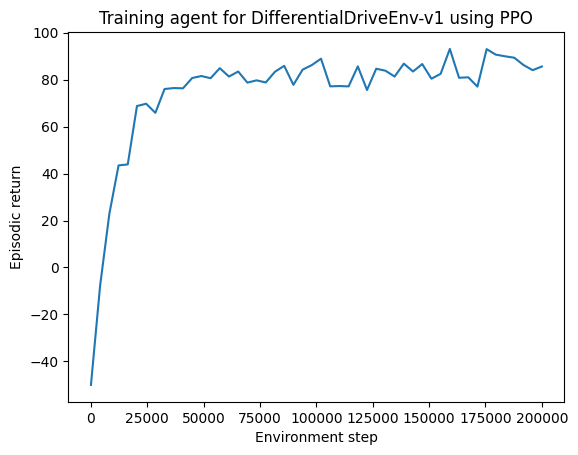

74.710205


In [20]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, ppo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env.name} using {ppo.__class__.__name__}")
plt.show()

print(mean_return.mean())

## Evaluatation

Let's evaluate the agent on the test set of rooms and visualize the results.

In [21]:
from eval import evaluate_model

# Set the seed for reproducibility
TEST_SEED = 77

evaluation = evaluate_model(
    agent=ppo, 
    train_state=train_state, 
    seed=TEST_SEED, 
    render=True,
    n_eval_episodes=10,
)

print(evaluation.returns.mean())


Evaluation finished, mean return: 97.44865417480469
97.448654


## Visualization

Visualize a few episodes of the agent playing the game.

In [ ]:
from env_vis import save_gif
from pathlib import Path
from IPython.display import Image as IPImage, display

if evaluation.rendered_frames is not None:
    path = Path("temp/ppo_policy.gif")
    save_gif(evaluation.rendered_frames, path)

    display(IPImage(filename=path))